In [2]:
import pandas as pd
import numpy as np
import sys
import importlib
sys.path.append('/mnt/c/Users/akpau/Repos/data_proc')
sys.path.append('/mnt/c/Users/akpau/Repos/median_polish')
import plate_maps as pm
from median_polish import main as mp
import matplotlib.pyplot as plt
import seaborn as sns
%config completer.use_jedi=False

# Pull data from db in plate array format

In [3]:
cnx=pm.create_mysql_cnx()

In [4]:
query="""select HAR_HA_ID, HAP_BARCODE, HAR_HAV_ID, HAW_COORDINATES, HART_SDESC, HART_TYPE_ID, HAR_VALUE_INT, HAR_VALUE_DOU, HAR_VALUE_STR
from HTS_ASSAY_RESULT
inner join HTS_ASSAY_PLATE on HTS_ASSAY_RESULT.HAR_HAP_ID=HAP_ID
inner join HTS_ASSAY_RESULT_TYPE on HAR_HART_ID=HART_ID
inner join HTS_ASSAY_WELL on HAR_HAW_ID=HAW_ID
where HAR_HA_ID=2268
"""

with cnx.connect() as conn:
    info=pd.read_sql_query(sql=query, con=conn)

In [5]:
info.head()

,HAR_HA_ID,HAP_BARCODE,HAR_HAV_ID,HAW_COORDINATES,HART_SDESC,HART_TYPE_ID,HAR_VALUE_INT,HAR_VALUE_DOU,HAR_VALUE_STR
0,2268,05035PK-PT05,7304,A02,intensity,3,76112.0,NaN,None
1,2268,05035PK-PT05,7304,A02,foldchange_intensity,3,NaN,0.713521,None
2,2268,05035PK-PT05,7304,A02,activation_intensity,3,NaN,-10.947318,None
3,2268,05035PK-PT05,7304,A02,standardscore_intensity,3,NaN,-0.288402,None
4,2268,05035PK-PT05,7304,A03,intensity,1,75488.0,NaN,None


In [6]:
info.HART_SDESC.unique()

array(['intensity', 'foldchange_intensity', 'activation_intensity',
       'standardscore_intensity', 'bscore_intensity'], dtype=object)

In [7]:
info['row']=info.HAW_COORDINATES.str[0]
info['col']=info.HAW_COORDINATES.str[1:].astype(int)
info['plate']=info.HAP_BARCODE+'_'+info.HAR_HAV_ID.astype(str)+'_'+info.HART_SDESC
info.head()

,HAR_HA_ID,HAP_BARCODE,HAR_HAV_ID,HAW_COORDINATES,HART_SDESC,HART_TYPE_ID,HAR_VALUE_INT,HAR_VALUE_DOU,HAR_VALUE_STR,row,col,plate
0,2268,05035PK-PT05,7304,A02,intensity,3,76112.0,NaN,None,A,2,05035PK-PT05_7304_intensity
1,2268,05035PK-PT05,7304,A02,foldchange_intensity,3,NaN,0.713521,None,A,2,05035PK-PT05_7304_foldchange_intensity
2,2268,05035PK-PT05,7304,A02,activation_intensity,3,NaN,-10.947318,None,A,2,05035PK-PT05_7304_activation_intensity
3,2268,05035PK-PT05,7304,A02,standardscore_intensity,3,NaN,-0.288402,None,A,2,05035PK-PT05_7304_standardscore_intensity
4,2268,05035PK-PT05,7304,A03,intensity,1,75488.0,NaN,None,A,3,05035PK-PT05_7304_intensity


In [8]:
importlib.reload(mp)

<module 'median_polish.main' from '/mnt/c/Users/akpau/Repos/median_polish/median_polish/main.py'>

In [9]:
array_labs=[]
arrays=[]
polishes=[]
mads=[]
bscores=[]
for plate in info.plate.unique():
    if any([x in plate for x in ['foldchange','standardscore','bscore']]):
        continue
    tmp=info[(info.plate==plate)&(info.HART_TYPE_ID)==1]
    tmp=tmp.dropna(how='all', axis=1)
    column=[x for x in tmp.columns if 'HAR_VALUE' in x]
    column=column[0]
    tmp=pd.pivot_table(data=tmp, columns='col', index='row',dropna=True, values=column)
    array_labs.append(plate)
    arrays.append(tmp)
    tmp=tmp.fillna(np.nanmean(tmp.values))
    polish=mp.median_polish(tmp.values)
    polishes.append(polish)
    mad=mp.med_abs_dev(polish['r'])
    mads.append(mad)
    bscore=polish['r']/mad
    bscore=pd.DataFrame(bscore, index=tmp.index, columns=tmp.columns)
    bscores.append(bscore)

In [10]:
idx=1
tmplab=array_labs[idx]
tmp=arrays[idx]
polish=polishes[idx]
mad=mads[idx]
bscore=bscores[idx]
tmplab

'05035PK-PT05_7304_activation_intensity'

<AxesSubplot: xlabel='col', ylabel='row'>

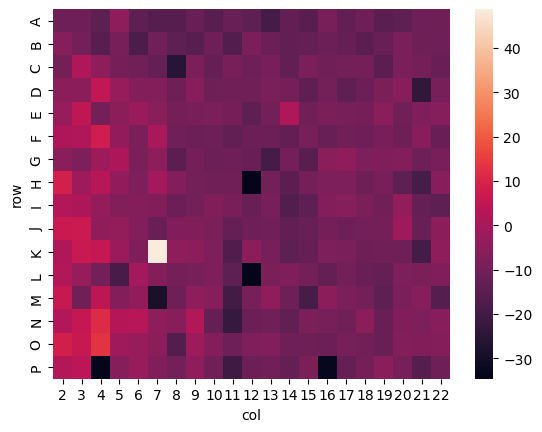

In [11]:
sns.heatmap(tmp, vmax=tmp.max().max(), vmin=tmp.min().min())

<AxesSubplot: xlabel='col', ylabel='row'>

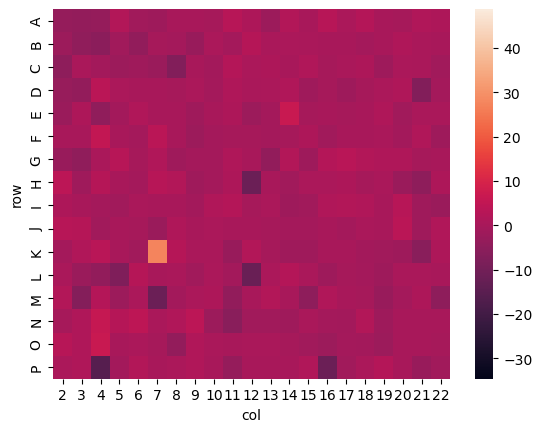

In [12]:
sns.heatmap(bscore, vmax=tmp.max().max(), vmin=tmp.min().min())

### From pipeline pilot:
```
 X' = (Residual)/MAD 
 where 
 Residual = X - (Mean + RowEffect + ColumnEffect + Smoothing) 
 MAD = Median Absolute Deviation of the Residuals 
```

In [13]:
data=arrays[idx].values

In [16]:
n_iter=10
tol=0.01

assert data.ndim == 2, "Input must be 2D array"
ndim = 2
data = data.copy()
grand_effect = np.mean(data) # changed to mean to match PLP
data -= grand_effect
median_margins = [0] * ndim
margins = [np.zeros(shape=data.shape[idx]) for idx in range(2)]
dim_mask = np.ones(ndim, dtype=int)
stop=False

for i in range(n_iter):                                     # for num of iterations,
    print('\tIteration', i)
    for dim_id in range(ndim):                                # for each dimension,
        rest_dim = 1 - dim_id                                   # define other dimension
        temp_median = np.median(data, rest_dim)                 # get medians along other dimension aka effects
        margins[dim_id] += temp_median                          # add medians as effects for original dimension
        median_margins[rest_dim] = np.median(margins[rest_dim]) # the effect median is labeled by the other dimension
        margins[rest_dim] -= median_margins[rest_dim]           # subtract median from the effects of the other dimension
        dim_mask[dim_id] = -1                                   # mask out original dimension
        data -= temp_median.reshape(dim_mask)                   # subtract medians along the matching dimension by reshaping medians to align with data dimension
        dim_mask[dim_id] = 1                                    # reset mask
    grand_effect += sum(median_margins)                       # add the median of row and column effects to the grand effect
    if stop:
        break
polishdict={'ave': grand_effect, 'row': margins[1], 'column': margins[0], 'r': data}

	Iteration 0
	Iteration 1
	Iteration 2
	Iteration 3
	Iteration 4
	Iteration 5
	Iteration 6
	Iteration 7
	Iteration 8
	Iteration 9


In [17]:
margins

[array([-4.95788942, -2.54786026, -0.90727612, -0.063139  ,  1.10897389,
        -0.17884906, -0.80386921,  0.09054402, -0.63136764,  0.063139  ,
         1.39559585,  0.42406124,  1.38543092,  1.7142575 ,  2.11385798,
        -0.40704506]),
 array([ 1.04263148e+01,  1.12437577e+01,  7.53829873e+00,  5.50640391e+00,
         2.76832061e+00,  2.56493242e+00, -1.28783974e+00,  2.19792017e+00,
        -3.05233417e-01, -3.45870754e+00, -1.56709549e+00, -4.92428245e-01,
        -2.98836675e+00, -1.46027415e+00, -1.53929306e-03, -4.70038528e-01,
        -1.31635305e+00, -1.50100664e-01,  5.29880645e-01,  4.60836354e-02,
         1.23726137e+00])]

In [18]:
bscore=pd.DataFrame(bscore, index=tmp.index, columns=tmp.columns)

In [19]:
bscore=bscore.melt(value_name='activation_bscore', ignore_index=False)

In [20]:
bscore=bscore.reset_index()

In [21]:
tmp=info[info.plate==tmplab.replace('activation','bscore')]
tmp=tmp.merge(bscore, how='left')
tmp.head()

,HAR_HA_ID,HAP_BARCODE,HAR_HAV_ID,HAW_COORDINATES,HART_SDESC,HART_TYPE_ID,HAR_VALUE_INT,HAR_VALUE_DOU,HAR_VALUE_STR,row,col,plate,activation_bscore
0,2268,05035PK-PT05,7304,A03,bscore_intensity,1,NaN,-4.398978,None,A,3,05035PK-PT05_7304_bscore_intensity,-3.955713
1,2268,05035PK-PT05,7304,A04,bscore_intensity,1,NaN,-3.951451,None,A,4,05035PK-PT05_7304_bscore_intensity,-3.610028
2,2268,05035PK-PT05,7304,A05,bscore_intensity,1,NaN,2.067302,None,A,5,05035PK-PT05_7304_bscore_intensity,2.137523
3,2268,05035PK-PT05,7304,A06,bscore_intensity,1,NaN,-1.579440,None,A,6,05035PK-PT05_7304_bscore_intensity,-1.271655
4,2268,05035PK-PT05,7304,A07,bscore_intensity,1,NaN,-2.215322,None,A,7,05035PK-PT05_7304_bscore_intensity,-1.927034


Text(0, 0.5, 'Python_bscore')

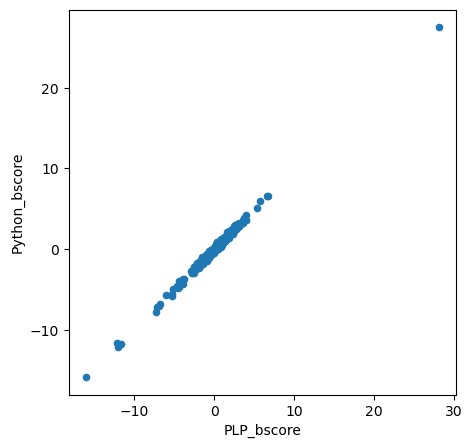

In [22]:
fig, ax=plt.subplots(1, figsize=(5,5))
tmp.plot(x='HAR_VALUE_DOU',y='activation_bscore',kind='scatter', ax=ax)
ax.set_xlabel('PLP_bscore')
ax.set_ylabel('Python_bscore')

In [119]:
polish

{'ave': -9.620290546882284,
 'row': array([ 1.04263148e+01,  1.12437577e+01,  7.53829873e+00,  5.50640391e+00,
         2.76832061e+00,  2.56493242e+00, -1.28783974e+00,  2.19792017e+00,
        -3.05233417e-01, -3.45870754e+00, -1.56709549e+00, -4.92428245e-01,
        -2.98836675e+00, -1.46027415e+00, -1.53929306e-03, -4.70038528e-01,
        -1.31635305e+00, -1.50100664e-01,  5.29880645e-01,  4.60836354e-02,
         1.23726137e+00]),
 'column': array([-4.95788942, -2.54786026, -0.90727612, -0.063139  ,  1.10897389,
        -0.17884906, -0.80386921,  0.09054402, -0.63136764,  0.063139  ,
         1.39559585,  0.42406124,  1.38543092,  1.7142575 ,  2.11385798,
        -0.40704506]),
 'r': array([[-6.79545269e+00, -7.83643461e+00, -7.15161712e+00,
          4.23452244e+00, -2.51920142e+00, -3.81753634e+00,
         -1.65376049e-01,  0.00000000e+00, -7.69685711e-01,
          5.85723958e+00,  1.86780059e+00, -4.39411634e+00,
          4.24627704e+00,  3.45232647e-01,  5.65571533e+00,
 